In [1]:
%load_ext autoreload

%autoreload 2

from __future__ import division, print_function

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join
%matplotlib inline
import matplotlib
matplotlib.rc("figure", dpi=144)
import matplotlib.pyplot as plt

import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [19]:
name = "heavysimple"

In [20]:
d = join("derivative-runs",name)
params = pickle.load(open(join(d,"params.pickle"),"rb"))
F = threebody.Fitter(**params)
try:
    F.best_parameters = pickle.load(
        open(join(d,"best_parameters.pickle"),"rb"))
except IOError:
    pass
derivatives = {}
for p in F.parameters:
    derivatives[p] = np.load(join(d,"%s.npy" % p))
print("Goodness of fit:",F.goodness_of_fit())
M, linear_parameters = F.compute_linear_matrix()
lv, linear_parameters = F.compute_linear_parts()
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

ps = F.parameters + linear_parameters
Abig = np.array([derivatives[p] 
                 for p in ps], 
                dtype=np.longdouble).T
#print(Abig.shape)
result = threebody.lstsq_with_errors(Abig, 
                                     F.residuals(), 
                                     F.phase_uncerts)

for i,p in enumerate(ps):
    if p in F.parameters:
        v = F.best_parameters[p]
    elif p in linear_parameters:
        v = lv[linear_parameters.index(p)]
    else:
        v = 0
    print(p, 
          threebody.fmt(v-result.x[i], result.uncerts[i]), 
          result.uncerts[i])

Goodness of fit: 36128.6298498
asini_i 1.2175254(3)e0 2.65893958596e-07
pb_i 1.6293937(7)e0 6.85957863643e-07
eps1_i 6.882(2)e-4 2.07677846742e-07
eps2_i -9.1390(18)e-5 1.83256173559e-08
tasc_i 4.0771667(7)e-1 6.56833452944e-08
acosi_i 1.48974(19)e0 0.000186301945142
q_i 1.37410(4)e-1 4.27524396428e-06
asini_o 7.4672641(13)e1 1.29920251893e-05
pb_o 3.2725695(11)e2 0.000113151350936
eps1_o 3.518600(5)e-2 4.9598261435e-08
eps2_o -3.46297(16)e-3 1.64999919066e-07
tasc_o 3.1393523(11)e2 0.000113099503984
acosi_o 9.1377(12)e1 0.0121393103988
delta_lan 6.3(8)e-6 7.84782499682e-07
delta -9.6(19)e-7 1.92407410302e-07
dgamma 0(3)e-2 0.0257697147847
dbeta 4(5)e-2 0.0496188334149
DM_0001 -1.95(8)e-1 0.00823042991413
DM_0002 -1.34(10)e-1 0.00981103279452
DM_0003 -1.43(11)e-1 0.010763099039
DM_0004 -1.64(9)e-1 0.00933630862652
DM_0005 -2.98(18)e-1 0.0175895122559
FD1 3.4(13)e-3 0.00130133817317
FD2 -7(6)e-3 0.00584999486429
FD3 0(11)e-3 0.0110693217594
FD4 -2(8)e-3 0.00750885322388
IPM_0000 7.3(6)e

In [21]:
# FIXME
bp = F.best_parameters.copy()
for p in F.parameters:
    i = ps.index(p)
    bp[p] -= result.x[i]
pre = F.goodness_of_fit(F.best_parameters)
print("pre-improvement:", pre)
post = F.goodness_of_fit(bp)
print("post-improvement:", post)
if post<pre:
    with open("derivative-best-parameters.pickle","wb") as f:
        pickle.dump(bp, f)

pre-improvement: 36128.6298498
post-improvement: 214200.401113


In [22]:
F.parameters

['asini_i',
 'pb_i',
 'eps1_i',
 'eps2_i',
 'tasc_i',
 'acosi_i',
 'q_i',
 'asini_o',
 'pb_o',
 'eps1_o',
 'eps2_o',
 'tasc_o',
 'acosi_o',
 'delta_lan',
 'delta',
 'dgamma',
 'dbeta']

In [23]:
np.median(F.phase_uncerts)/F.reference_f0*1e6

1.24043120876

In [24]:
dir(result)

['__doc__',
 '__module__',
 'chi2',
 'corr',
 'cov',
 'reduced_chi2',
 'residuals',
 'residuals_scaled',
 'singular_values',
 'uncerts',
 'x']

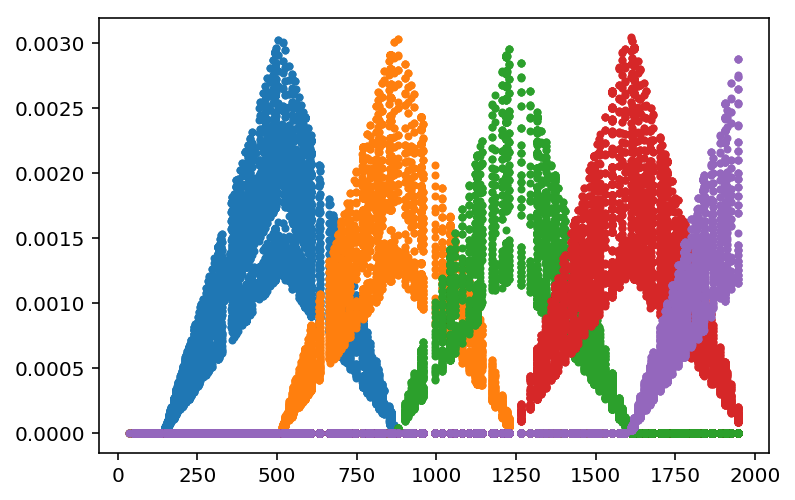

In [27]:
i = 1
while True:
    dmn = "DM_%04d" % i
    if dmn not in derivatives:
        break
    plt.plot(F.mjds, derivatives[dmn], ".")
    i += 1

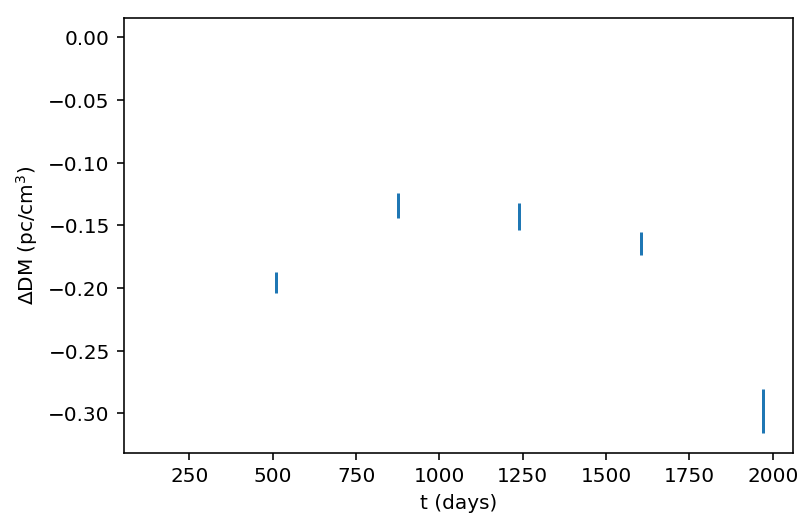

In [32]:
epochs = F.dmx_epochs
dms = [0]
dmus = [0]
i = 1
while True:
    dmn = "DM_%04d" % i
    if dmn not in derivatives:
        break
    ix = ps.index(dmn)
    ix2 = linear_parameters.index(dmn)
    dms.append(lv[ix2] - result.x[ix])
    dmus.append(result.uncerts[ix])
    i += 1
plt.errorbar(epochs, dms, dmus, linestyle="none")
plt.xlabel("t (days)")
plt.ylabel("$\Delta$DM (pc/cm$^3$)")

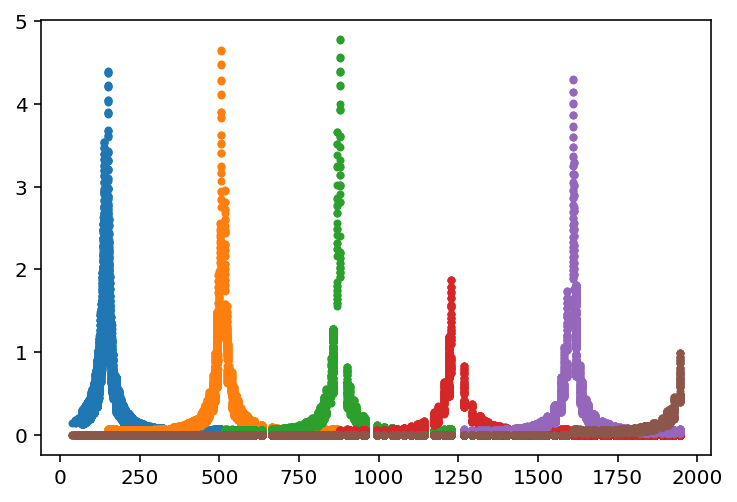

In [36]:
i = 0
while True:
    ipmn = "IPM_%04d" % i
    if ipmn not in derivatives:
        break
    plt.plot(F.mjds, derivatives[ipmn], ".")
    i += 1

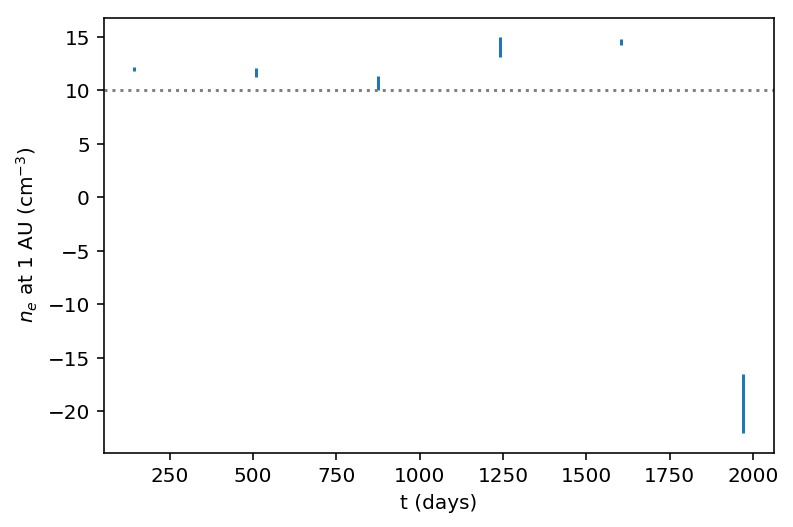

In [44]:
epochs = F.dmx_epochs
ipms = []
ipmus = []
i = 0
while True:
    ipmn = "IPM_%04d" % i
    if ipmn not in derivatives:
        break
    ix = ps.index(ipmn)
    ix2 = linear_parameters.index(ipmn)
    ipms.append(lv[ix2]-result.x[ix])
    ipmus.append(result.uncerts[ix])
    i += 1
ipms = np.array(ipms)
ipmus = np.array(ipmus)
f = 1/F.reference_f0
plt.errorbar(epochs, (f*ipms+1)*10, f*ipmus*10, linestyle="none")
#plt.errorbar(epochs, ipms, ipmus, linestyle="none")
plt.axhline(10,linestyle=":", color="gray")
plt.xlabel("t (days)")
plt.ylabel("$n_e$ at 1 AU (cm$^{-3}$)")

In [26]:
ips = ["DM_0001", "FD1", "FD2", "FD3", "FD4", "IPM_0001"]
M = np.zeros((len(ips),len(ips)))
for i,p in enumerate(ips):
    ii = ps.index(p)
    for j,q in enumerate(ips):
        jj = ps.index(q)
        M[i,j] = result.corr[ii,jj]
M

array([[ 1.        , -0.0502678 ,  0.07038861, -0.08250035,  0.09284707,
        -0.44597547],
       [-0.0502678 ,  1.        , -0.99500378,  0.98223201, -0.96395602,
         0.00258855],
       [ 0.07038861, -0.99500378,  1.        , -0.99591848,  0.98506842,
        -0.00315702],
       [-0.08250035,  0.98223201, -0.99591848,  1.        , -0.99651814,
         0.00321797],
       [ 0.09284707, -0.96395602,  0.98506842, -0.99651814,  1.        ,
        -0.00314616],
       [-0.44597547,  0.00258855, -0.00315702,  0.00321797, -0.00314616,
         1.        ]])